In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime 
from scipy.sparse import hstack,csr_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from collections import defaultdict
import math
from sklearn.model_selection import GridSearchCV

#MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from google.colab import files
import timeit

**Importing DATA**

In [ ]:
DATA = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Applied Ai/PROJECT/Case Study 1/Final_Data.pkl')
DATA.shape

(949614, 414)

**Splitting Dataset into Training and Testing**

In [ ]:
#Can Break After Customer Data Clean
#Splitting based on latest date, as we sorted based on date and ids

X = DATA.iloc[:,:-24]
Y = DATA.iloc[:,-24:]

#selecting 80% Data as Train data, 20% Test Data
breakpt = math.floor(len(DATA)*0.8)

XTrain_Cust = X.iloc[:breakpt,:].copy()
XTest_Cust = X.iloc[breakpt:,:].copy()

YTrain = Y.iloc[:breakpt,:].copy()
YTest = Y.iloc[breakpt:,:].copy()


#id and Product Data
ilocPD = [0]+list(np.arange(-24,0))
Prod_DATA_Train = DATA.iloc[:breakpt,ilocPD]
Prod_DATA_Test = DATA.iloc[breakpt:,ilocPD]

print('XTrain_Cust.shape  ',XTrain_Cust.shape)
print('XTest_Cust  ',XTest_Cust.shape)
print('YTrain  ',YTrain.shape)
print('YTest  ',YTest.shape)
print('Prod_DATA_Train  ',Prod_DATA_Train.shape)
print('Prod_DATA_Test  ',Prod_DATA_Test.shape)

XTrain_Cust.shape   (759691, 390)
XTest_Cust   (189923, 390)
YTrain   (759691, 24)
YTest   (189923, 24)
Prod_DATA_Train   (759691, 25)
Prod_DATA_Test   (189923, 25)


**Modelling:**
- Here, We are going to use advantages of both Content based filtering and Collaborative filtering
- In First Model, We'll use **Collborative filtering**
 - In which, Model will be trained only on Product Data.
 - It'll use product purchasing behaviour of Customers into account
- In Second Model,We'll be training **Content based filtering** Model
 - In which, Model will be trained on Customer Related Data
 - This Model will user Customer Information to Predict Probabilities

- In Our Final Customized Model, We'll be taking Average of the probabilities of both the Models to predct the output.
- We'll be using Logistic Regression to train both models,
- Why Logistic Regression?
 - Binary Classification in each iteration
 - Gives Probability Score
 - Workd well on High Dimentional Data
 - Multicollinearity does not affect

**Modeling**

**Model A**
- 1. Logistic Regression

HyperParameter Tuning on Logistic Regression

In [ ]:
def return_BestParameters(data,model,params):
  '''
  This Function Returns best Hyperparameter for Given Model for each Product
  '''

  #Store List of Best Prameters
  bestParams = {}
  bestAccuracy = {}

  #Stores unique ids
  ids = data['ncodpers'].values

  for c in data.columns:
      if c != 'ncodpers':
          print('\nProduct ',c,end=' ')
          y_train = data[c]
          x_train = data.drop([c, 'ncodpers'],axis=1)
          
          clf = GridSearchCV(model,params,scoring='accuracy')
          clf.fit(x_train, y_train)

          bestParams[c] = clf.best_params_
          bestAccuracy[c] = clf.best_score_
          print(' Accuracy ',clf.best_score_)

  return bestParams,bestAccuracy

In [ ]:
#Getting Best Hyperparameters 
start = timeit.default_timer()

#1. Logistic Regression
print('-'*50)
print('LogisticRegression')
print('-'*50)
#We are using solver as liblinear, because we are hypertuning penalty l1 and l2
logReg = LogisticRegression(solver='liblinear')
params = {'C':[0.1,1,10],'penalty':['l1','l2']}
bestParams_logReg,bestAccuracy_logReg = return_BestParameters(Prod_DATA_Train,logReg,params)

stop = timeit.default_timer()
print('Time: ', stop - start)
start = timeit.default_timer()

#2. Naive Bayes
print('-'*50)
print('Naive Bayes')
print('-'*50)
naiveB = MultinomialNB()
params = {'alpha':[0.1,1,10]}
bestParams_nB,bestAccuracy_nB = return_BestParameters(Prod_DATA_Train,naiveB,params)

stop = timeit.default_timer()
print('Time: ', stop - start)
start = timeit.default_timer()

#3. Random Forest Classifier
print('-'*50)
print('Random Forest Classifier')
print('-'*50)
rf = RandomForestClassifier()
params = {'n_estimators':[50,100],'max_depth':[3,5]}
bestParams_rf,bestAccuracy_rf = return_BestParameters(Prod_DATA_Train,rf,params)

stop = timeit.default_timer()
print('Time: ', stop - start)
start = timeit.default_timer()
#4. Light Gradient Boosting Machine
print('-'*50)
print('LGBT')
print('-'*50)
lgbb = lgb.LGBMClassifier()
params = {'max_depth':[3,5],'learning_rate':[0.01,0.1,1]}
bestParams_lgbm,bestAccuracy_lgbm = return_BestParameters(Prod_DATA_Train,lgbb,params)

stop = timeit.default_timer()
print('Time: ', stop - start)
start = timeit.default_timer()

--------------------------------------------------
LogisticRegression
--------------------------------------------------

Product  ind_ahor_fin_ult1  Accuracy  0.9998828471066734

Product  ind_aval_fin_ult1  Accuracy  0.9999710408625992

Product  ind_cco_fin_ult1  Accuracy  0.655998297584231

Product  ind_cder_fin_ult1  Accuracy  0.9994826844106749

Product  ind_cno_fin_ult1  Accuracy  0.9836946852883852

Product  ind_ctju_fin_ult1  Accuracy  0.9898945755628219

Product  ind_ctma_fin_ult1  Accuracy  0.9872922016994401

Product  ind_ctop_fin_ult1  Accuracy  0.8539274732204651

Product  ind_ctpp_fin_ult1  Accuracy  0.9494636728339548

Product  ind_deco_fin_ult1  Accuracy  0.9977438195283405

Product  ind_deme_fin_ult1  Accuracy  0.9975911258742949

Product  ind_dela_fin_ult1  Accuracy  0.9380577315536177

Product  ind_ecue_fin_ult1  Accuracy  0.9070793241893629

Product  ind_fond_fin_ult1  Accuracy  0.9745673084827663

Product  ind_hip_fin_ult1  Accuracy  0.9933551932489457

Product  ind

"\n#4. Light Gradient Boosting Machine\nprint('-'*50)\nprint('LGBT')\nprint('-'*50)\nlgbb = lgb.LGBMClassifier()\nparams = {'max_depth':[3,5],'learning_rate':[0.01,0.1,1]}\nbestParams_lgbm,bestAccuracy_lgbm = return_BestParameters(Prod_DATA_Train,lgbb,params)\n\nstop = timeit.default_timer()\nprint('Time: ', stop - start)\nstart = timeit.default_timer()"

In [ ]:
#To Save Best Accuracies and Parameters in File to use later
'''
json_object = json.dumps(bestParams_logReg, indent = 4)

try:
    geeky_file = open('bestParams_logReg.txt', 'wt')
    geeky_file.write(json_object)
    geeky_file.close()
except:
    print("Unable to write to file")
files.download("bestParams_logReg.txt")

json_object = json.dumps(bestAccuracy_logReg, indent = 4)

try:
    geeky_file = open('bestAccuracy_logReg.txt', 'wt')
    geeky_file.write(json_object)
    geeky_file.close()
except:
    print("Unable to write to file")
files.download("bestAccuracy_logReg.txt")

json_object = json.dumps(bestParams_nB, indent = 4)

try:
    geeky_file = open('bestParams_nB.txt', 'wt')
    geeky_file.write(json_object)
    geeky_file.close()
except:
    print("Unable to write to file")
files.download("bestParams_nB.txt")

json_object = json.dumps(bestAccuracy_nB, indent = 4)

try:
    geeky_file = open('bestAccuracy_nB.txt', 'wt')
    geeky_file.write(json_object)
    geeky_file.close()
except:
    print("Unable to write to file")
files.download("bestAccuracy_nB.txt")


json_object = json.dumps(bestParams_rf, indent = 4)

try:
    geeky_file = open('bestParams_rf.txt', 'wt')
    geeky_file.write(json_object)
    geeky_file.close()
except:
    print("Unable to write to file")
files.download("bestParams_rf.txt")

json_object = json.dumps(bestAccuracy_rf, indent = 4)

try:
    geeky_file = open('bestAccuracy_rf.txt', 'wt')
    geeky_file.write(json_object)
    geeky_file.close()
except:
    print("Unable to write to file")
files.download("bestAccuracy_rf.txt")


json_object = json.dumps(bestParams_lgbm, indent = 4)

try:
    geeky_file = open('bestParams_lgbm.txt', 'wt')
    geeky_file.write(json_object)
    geeky_file.close()
except:
    print("Unable to write to file")
files.download("bestParams_lgbm.txt")

json_object = json.dumps(bestAccuracy_lgbm, indent = 4)

try:
    geeky_file = open('bestAccuracy_lgbm.txt', 'wt')
    geeky_file.write(json_object)
    geeky_file.close()
except:
    print("Unable to write to file")
files.download("bestAccuracy_lgbm.txt")

#Retriving Files
def returnDict(name):
 
  This Function Retrieves saved files
 
  path = '/content/drive/MyDrive/Colab Notebooks/Applied Ai/PROJECT/Case Study 1/'+name+'.txt'
  with open(path) as json_file:
      dicttt = json.load(json_file)
  return dicttt

bestAccuracy_logReg = returnDict('bestAccuracy_logReg')
bestParams_logReg = returnDict('bestParams_logReg')
bestParams_rf = returnDict('bestParams_rf')
bestAccuracy_rf = returnDict('bestAccuracy_rf')
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'\njson_object = json.dumps(bestParams_lgbm, indent = 4)\n\ntry:\n    geeky_file = open(\'bestParams_lgbm.txt\', \'wt\')\n    geeky_file.write(json_object)\n    geeky_file.close()\nexcept:\n    print("Unable to write to file")\nfiles.download("bestParams_lgbm.txt")\n\njson_object = json.dumps(bestAccuracy_lgbm, indent = 4)\n\ntry:\n    geeky_file = open(\'bestAccuracy_lgbm.txt\', \'wt\')\n    geeky_file.write(json_object)\n    geeky_file.close()\nexcept:\n    print("Unable to write to file")\nfiles.download("bestAccuracy_lgbm.txt")'

In [ ]:
#Finding the model using averages of probabilities
Accuracies = [bestAccuracy_logReg,bestAccuracy_nB,bestAccuracy_rf,bestAccuracy_lgbm]
labbels = ['logistic Regression','Naive Bayes','Random Forest','LGBM']
AvgAccuracy = dict()
for i,j in zip(labbels,Accuracies):
  sum = 0
  for k in j.values():
    sum+=k
  AvgAccuracy[i] = sum/len(j)

In [4]:
#AvgAccuracy = {'logistic Regression': 0.9549822508397751, 'Naive Bayes': 0.9531768599683642, 'Random Forest': 0.9571864846233221, 'LGBM': 0.9571190240531747}

{'logistic Regression': 0.9549822508397751, 'Naive Bayes': 0.9531768599683642, 'Random Forest': 0.9571864846233221, 'LGBM': 0.9571190240531747}


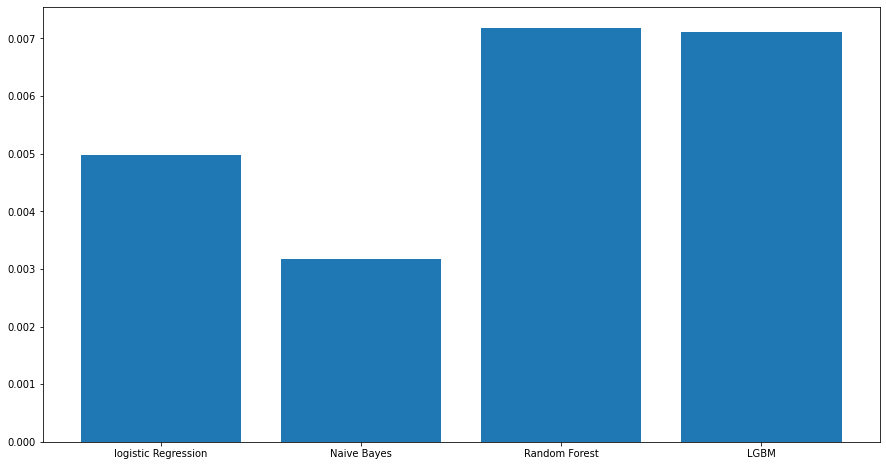

In [6]:
col = AvgAccuracy.keys()
#Checking the Difference 
val = AvgAccuracy.values()
val = [i-0.95 for i in val]

print(AvgAccuracy)

fig = plt.figure(figsize =(15, 8))
plt.bar(col,val )
plt.show()

**OBSERVATION:**
- All accuracies are pretty good, but Random Forest has the best Acuracy
- We'll be Using 'Random Forest' to train the Model

**Time Taken By Each Algorithm to run is as follows**


In [2]:
import matplotlib.pyplot as plt


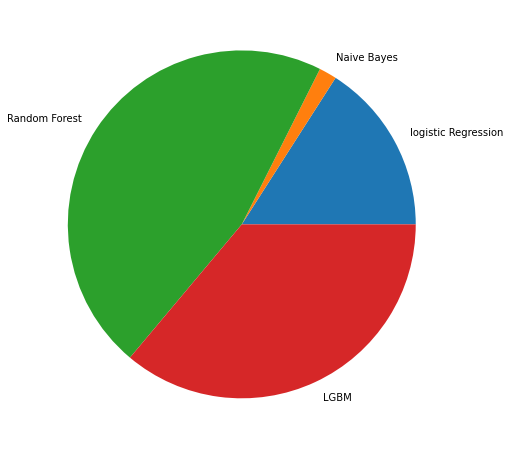

In [3]:
labbels = ['logistic Regression','Naive Bayes','Random Forest','LGBM']
Time = [25.50,2.63,74.10,57.78]

fig = plt.figure(figsize =(15, 8))
plt.pie(Time, labels = labbels)
plt.show()

**OBSERVATION:**
- Random Forest took the highest time
- Naive bayes has only 1 parameter for tuning, still it took way less time than others
- LGBM has 1 prameter more to tune than Random Forest, Still it took less time than Random Forest.

**MODEL A**

In [7]:
from sklearn.model_selection import train_test_split

In [ ]:
#Store List of Models
models = {}
#Stores List of Probabilities of each model
model_preds = {}
#creating default dictionary to store ids of predictions

id_preds = defaultdict(list)
#Stores unique ids

ModelAccuracy = dict()
ModelPrecision = dict()
ModelRecall = dict()

ids = Prod_DATA_Train['ncodpers'].values

for c in Prod_DATA_Train.columns:
    if c != 'ncodpers':
        print('Product ',c)
        y_new = Prod_DATA_Train[c]
        x_new = Prod_DATA_Train.drop([c, 'ncodpers'],axis=1)

        x_train,x_test,y_train,y_test = train_test_split(x_new,y_new,random_state=42,stratify=y_new)

        maxDepth = bestParams_rf[c]['max_depth']
        nEstimators = bestParams_rf[c]['n_estimators']
        clf = RandomForestClassifier(max_depth=maxDepth,n_estimators=nEstimators )
        clf.fit(x_train, y_train)

        #Stores Probability Value, [:,1]-> to not to gate index values
        p_train = clf.predict_proba(x_train)[:,1]
        
        #Getting Predictions
        y_pred = clf.predict(x_test)

        models[c] = clf
        #Storing Probabilities of Each Model For each User 
        model_preds[c] = p_train

        for id, p in zip(ids, p_train):
            id_preds[id].append(p)
 
        ModelAccuracy[c] =  accuracy_score(y_test, y_pred)
        ModelRecall[c] =  recall_score(y_test, y_pred,zero_division=0)
        ModelPrecision[c] = precision_score(y_test, y_pred,zero_division=0)

        print(roc_auc_score(y_train, p_train))


Product  ind_ahor_fin_ult1
0.7376950197070973
Product  ind_aval_fin_ult1
0.9775067406749759
Product  ind_cco_fin_ult1
0.6518088025670001
Product  ind_cder_fin_ult1
0.8088032207893757
Product  ind_cno_fin_ult1
0.9822782897807705
Product  ind_ctju_fin_ult1
0.8678594623794588
Product  ind_ctma_fin_ult1
0.74530540693312
Product  ind_ctop_fin_ult1
0.6143451662546868
Product  ind_ctpp_fin_ult1
0.7447061062887063
Product  ind_deco_fin_ult1
0.7647211897201852
Product  ind_deme_fin_ult1
0.8682338128674747
Product  ind_dela_fin_ult1
0.8092268375788216
Product  ind_ecue_fin_ult1
0.8257953120755304
Product  ind_fond_fin_ult1
0.8517008890153932
Product  ind_hip_fin_ult1
0.9048758920459269
Product  ind_plan_fin_ult1
0.8001953692326707
Product  ind_pres_fin_ult1
0.6951860425327434
Product  ind_reca_fin_ult1
0.8480564225481088
Product  ind_tjcr_fin_ult1
0.9039429106793019
Product  ind_valo_fin_ult1
0.8249202731406217
Product  ind_viv_fin_ult1
0.7684381761927243
Product  ind_nomina_ult1
0.9967476073263

In [ ]:
#Plot of Accuracies


**Model B**
- We're using Logistic regression for Content based filtering due to very high dimentional data nad low computing power

In [ ]:
def return_BestParameters_Customer(data,XTrain_Cust,model,params):
  '''
  This Function Returns best Hyperparameter for Given Model for each Product
  '''

  #Store List of Best Prameters
  bestParams = {}
  bestAccuracy = {}

  #Stores unique ids
  #We are using solver as liblinear, because we are hypertuning penalty l1 and l2
  ids = data['ncodpers'].values

  for c in data.columns:
      if c != 'ncodpers':
          print('\nProduct ',c,end=' ')
          y_train = data[c]
          x_train = XTrain_Cust.drop(['ncodpers'],axis=1)
          
          
          clf = GridSearchCV(model,params,scoring='accuracy')
          clf.fit(x_train, y_train)

          bestParams[c] = clf.best_params_
          bestAccuracy[c] = clf.best_score_
          print(' Accuracy ',clf.best_score_)

  return bestParams,bestAccuracy

In [ ]:
import warnings

In [ ]:
logReg = LogisticRegression(solver='liblinear')
params = {'C':[0.1,1,10],'penalty':['l1','l2']}
warnings.filterwarnings("ignore")
#ModelB_bestParams_logReg,ModelB_bestAccuracy_logReg = return_BestParameters_Customer(Prod_DATA_Train,XTrain_Cust,logReg,params)

In [ ]:
#We have best values of C as 0.1 and using l1 as penalty because of high dimentional data

In [ ]:
#Store List of Models
models2 = {}
#Stores List of Probabilities of each model
model_preds2 = {}
#creating default dictionary to store ids of predictions
id_preds2 = defaultdict(list)
#Stores unique ids
ids2 = XTrain_Cust['ncodpers'].values

ModelBAccuracy2 = dict()
ModelBPrecision2 = dict()
ModelBRecall2 = dict()

for c in Prod_DATA_Train.columns:
    if c != 'ncodpers':
        print('Product ',c)

        y_new = Prod_DATA_Train[c]
        x_new = XTrain_Cust.drop('ncodpers',axis=1)

        x_train2,x_test2,y_train2,y_test2 = train_test_split(x_new,y_new,random_state=42,stratify=y_new)

        clf2 = LogisticRegression(C=0.1,penalty='l1',solver='liblinear')
        clf2.fit(x_train2, y_train2)

        #Stores Probability Value, [:,1]-> to not to gate index values
        p_train2 = clf2.predict_proba(x_train2)[:,1]
        
        #Predicted Prob
        y_pred = clf2.predict(x_test2)

        models2[c] = clf2
        #Storing Probabilities of Each Model For each User 
        model_preds2[c] = p_train2

        for id, p in zip(ids2, p_train2):
            id_preds2[id].append(p)

        ModelBAccuracy2[c] =  accuracy_score(y_test2, y_pred)
        ModelBRecall2[c] =  recall_score(y_test2, y_pred)
        ModelBPrecision2[c] = precision_score(y_test2, y_pred)
            
        print(roc_auc_score(y_train2, p_train2))


Product  ind_ahor_fin_ult1
0.8630079681881899
Product  ind_aval_fin_ult1
0.8033571499261819
Product  ind_cco_fin_ult1
0.791505079190189
Product  ind_cder_fin_ult1
0.8989523867623354
Product  ind_cno_fin_ult1
0.8785810510572306
Product  ind_ctju_fin_ult1
0.998531395994706
Product  ind_ctma_fin_ult1
0.8963498958096702
Product  ind_ctop_fin_ult1
0.9006619760263744
Product  ind_ctpp_fin_ult1
0.8830036226596443
Product  ind_deco_fin_ult1
0.9323761496449934
Product  ind_deme_fin_ult1
0.8913250404454607
Product  ind_dela_fin_ult1
0.91377977992772
Product  ind_ecue_fin_ult1
0.8778574057189542
Product  ind_fond_fin_ult1
0.9194464651254721
Product  ind_hip_fin_ult1
0.9426729796938011
Product  ind_plan_fin_ult1
0.9226637954120784
Product  ind_pres_fin_ult1
0.9411384856944203
Product  ind_reca_fin_ult1
0.8638193529237006
Product  ind_tjcr_fin_ult1
0.8985668852804203
Product  ind_valo_fin_ult1
0.9110599978653233
Product  ind_viv_fin_ult1
0.8910022138539722
Product  ind_nomina_ult1
0.882975092322077

**From Given Discription of Data:**
- Big Problem in the Santander Product Recommendation was, Some Customers were getting lots of recommendations but some were hardly getting any. 
- To resolve this we are creating a threshold of 7 , So we'll be recommending 7 Products to each User
- In this new Solution, We'll be recommending the products which are not bought by the user. We'll name it as nonActive Products


In [ ]:
#Creating Dictionary of already bought Products
already_active = {}
for row in Prod_DATA_Train.values:
    row = list(row)
    id = row.pop(0)
    active = []
    for c in zip(Prod_DATA_Train.columns[1:], row):
      if (c[1] > 0):
        active.append(c[0])
    already_active[id] = active

#Taking Average of Probabiities
id_Pred_Final = {}
for i,j in id_preds.items():
  id_Pred_Final[i] = list((np.array(id_preds[i])+np.array(id_preds2[i]))/2)

In [ ]:
train_preds = {}

#To sort Dictionaries-> https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
for id, p in id_Pred_Final.items():
  NonActiveProds = {}
  NonActiveProds_sorted = {}
  for i in zip(Prod_DATA_Train.columns[1:], p):
    if i[0] not in already_active[id]:
      NonActiveProds[i[0]]=i[1]
  
  #Getting Top 7 Elements
  NonActiveProds_sorted = {k: v for k, v in sorted(NonActiveProds.items(), key=lambda item: item[1],reverse=True)[:7]}
  preds = list(NonActiveProds_sorted.keys())
  train_preds[id] = preds

In [ ]:
test_preds = {}
YPred_Dict = {}
for row in Prod_DATA_Train.values:
    id = row[0]
    if id in train_preds.keys():
      p = train_preds[id]
    else:
      #For New ID Recommending Most bought Products, Find More Deails in EDA
      p = ['ind_aval_fin_ult1','ind_ctma_fin_ult1','ind_cder_fin_ult1','ind_dela_fin_ult1','ind_recibo_ult1','ind_nom_pens_ult1','ind_deme_fin_ult1']
    YPred_Dict[id] = p
    test_preds[id] = ' '.join(p)

In [ ]:
test_preds = {int(k):v for k,v in test_preds.items()}

**Saving the Predictions file as Text File**

In [ ]:
test_preds = {1:[1,2,2],2:[4,4,4]}

In [ ]:
json_object = json.dumps(test_preds, indent = 4)

try:
    geeky_file = open('FinalPredictions.txt', 'wt')
    geeky_file.write(json_object)
    geeky_file.close()
  
except:
    print("Unable to write to file")

In [ ]:
files.download("FinalPredictions.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>